In [1]:
import os

import h5py
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
sns.set_context('notebook')

import sklearn
from sklearn import datasets
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import pairwise_distances
from sklearn import datasets

import scipy
from scipy.spatial.distance import pdist
from scipy.linalg import eigh
from scipy.spatial.distance import euclidean

import graphtools
#from pydiffmap.diffusion_map import DiffusionMap
import phate

Diffusion distance is defined by:
$D(x_i,x_j)^2 = \sum_k (P_{ik} - P_{jk})^2/\pi(x_k)$

The theory of diffusion maps is that we can eigendecompose our $P$ matrix and create maps for each point $x_i$. 

Specifically, let the eigendecomposition be: $P=\Psi\Lambda\Phi$ where:
* the right eigenvectors $\Psi=[\psi_1, ..., \psi_N]$ with $\psi_l=[\psi_l(x_1),...,\psi_l(x_N)]^T$
* $\Lambda$ be diagonal matrix of eigenvalues $\lambda_l$.

The diffusion map for $x_i$ is the ith row of: $DM(x_i)=\Psi\Lambda$

Eucidean distances of these maps preserve the "diffusion distances" of the points in ambient space:

$D(x_i,x_j)^2 = \sum_l \lambda_l^2 (\psi_l(x_i)-\psi_l(x_j))^2 = ||DM(x_i)-DM(x_j)||^2$

Implementation detail:

We eigendecompose the symmetric conjugate of $P$. Note that naive eigendecomposition of $P$ may result in non-orthogonal eigenvectors.

In [2]:
def compute_diffusion_distance_direct(P: np.ndarray, pi: np.ndarray, i: int) -> np.ndarray:
    """
    Compute the squared diffusion distance from point i to all other points using the diffusion matrix P.

    Parameters:
    P (np.ndarray): NxN diffusion matrix where P[i, j] is the transition probability from i to j.
    pi (np.ndarray): Stationary distribution, 1D array of length N.
    i (int): Index of the point from which distances are calculated.

    Returns:
    np.ndarray: A 1D array of diffusion distances from point i to all other points.
    """
    return np.array([euclidean(P[i], P[j], w=1/pi) for j in range(len(P))])**2

def compute_diffusion_distance_using_dmcoords(dm_coords, i):
    return pairwise_distances(dm_coords)[i]

def plot(data, palette, labels, label_order, ax=None, label_positions=True, **kwargs):
    if not ax:
        create_new_plot = True
        fig, ax = plt.subplots(figsize=(8, 5))
    else:
        create_new_plot = False

    sns.scatterplot(x=data[:, 0], 
                    y=data[:, 1], 
                    hue=labels, 
                    palette=palette, 
                    ax=ax, 
                    hue_order=label_order,
                    **kwargs)

    if create_new_plot:
        #ax.set_title(title)
        ax.legend(bbox_to_anchor=(1.1, 1.05), loc='upper left')
    else:
        # we dont need ticks or ticklabels
        ax.get_legend().remove()
        ax.xaxis.set_major_locator(ticker.NullLocator())
        ax.yaxis.set_major_locator(ticker.NullLocator())

    if label_positions:
        for label in label_order:
            indices = np.where(np.array(labels) == label)
            mean_position = np.mean(data[indices], axis=0)
            ax.text(mean_position[0], mean_position[1], label, weight='bold', ha='center')
            
def compute_dm(K, alpha=0.):
    # Using setup and notation from: https://www.stats.ox.ac.uk/~cucuring/CDT_08_Nonlinear_Dim_Red_b__Diffusion_Maps_FoDS.pdf
    # alpha=0 Graph Laplacian
    # alpha=0.5 Fokker-Plank operator
    # alpha=1 Laplace-Beltrami operator

    d_noalpha = K.sum(1).flatten()

    # weighted graph Laplacian normalization
    d = d_noalpha**alpha 
    D = np.diag(d)
    D_inv = np.diag(1/d)

    # Normalize K according to α
    K_alpha = D_inv@K@D_inv

    d_alpha = K_alpha.sum(1).flatten()
    D_alpha = np.diag(d_alpha)
    D_inv_alpha = np.diag(1/d_alpha)

    L = D_inv_alpha@K_alpha # anisotropic transition kernel (AKA diffusion operator)

    # build symmetric matrix
    D_sqrt_inv_alpha = np.diag(1/np.sqrt(d_alpha))
    D_sqrt_alpha = np.diag(np.sqrt(d_alpha))
    S = D_sqrt_inv_alpha@K_alpha@D_sqrt_inv_alpha

    # spectral decomposition of S
    # IMPORTANT NOTE:
    # In theory you could run np.linalg.eig(L),
    # BUT this returns non-orthogonal eigenvectors!
    # So would have to correct for that
    # Using SVD since more numerically stable
    evecs, svals, _ = scipy.linalg.svd(S)

    # Retrieve sign!
    test_product = S@evecs
    expected_product = evecs@np.diag(svals)
    signs = np.isclose(expected_product, test_product).mean(0)
    signs[~np.isclose(signs, 1)] = -1
    evals = svals*signs

    # convert right eigenvectors of S to those of L
    evecs_right = D_sqrt_inv_alpha@evecs
    evecs_left = D_sqrt_alpha@evecs

    # make sure ordered by eigenvalue
    order = np.argsort(evals)[::-1]
    evals = evals[order]
    #evecs = evecs[:, order]
    evecs_left = evecs_left[:, order]
    evecs_right = evecs_right[:, order]

    # Scaling factor for eigenvectors
    #scaling_factor = 1/d_noalpha.sum()
    #scaling_factor = evecs_right[0, 0]
    scaling_factor = 1/np.sqrt(d_alpha.sum())
    if np.isclose(evecs_right[:,0]/scaling_factor, -1).any():
        scaling_factor *= -1

    # Apply scaling
    evecs_right /= scaling_factor

    # Adjust left eigenvectors to maintain eigendecomposition
    # Assuming evecs_right[0,0] is non-zero for all practical cases
    evecs_left *= scaling_factor

    # Safety Checks!
    # First left eigenvector is stationary distribution
    neg_evals = evals < 0
    if neg_evals.sum() > 0:
        print("{} eigenvalues are negative: min={}".format(len(evals[neg_evals]),
                                                           evals[neg_evals].min()))
    one_evals = np.isclose(evals, 1).sum()
    if one_evals > 1:
        print("{} eigenvalues are 1".format(one_evals))
    if not np.allclose(evecs_left[:,0]/evecs_left.sum(), d_alpha/d_alpha.sum()):
        print("left evec not exactly stationary dist. Proceed with caution!")
    # First right eigenvector is all 1s
    if not  np.allclose(evecs_right[:,0], 1):
        print("right evec not trivial (1s)! Proceed with caution!")
    # Decomposition is correct
    if not np.allclose(L, evecs_right@np.diag(evals)@evecs_left.T):
        print("evals/evecs dont exactly match with diffusion operator. Proceed with caution!")


    #diffusion_coords = evecs_right@np.diag(evals)
    
    # return eigenvectors and eigenvalues instead so that we can compute DMs for different t's
    return evecs_right, evals, L, d_noalpha

def plot_change_in_diffusion_distance(P, pi, diffusion_coords, dims_to_plot):
    Dt = [compute_diffusion_distance_direct(P, pi, i) for i in range(len(P))]
    Dt = np.vstack(Dt) # ground truth

    distortion = []
    assert dims_to_plot[0] == 1
    assert dims_to_plot[-1] == len(diffusion_coords)

    for dims_keep in dims_to_plot:
        diff_dists = sklearn.metrics.pairwise_distances(diffusion_coords[:,:dims_keep])**2
        distortion.append(np.sqrt(((diff_dists - Dt)**2).mean()))

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(x=dims_to_plot, y=distortion)
    ax.set_xlabel('# Dims to Keep')
    ax.set_ylabel('RMSE diffusion dist vs Euclid. dist. of DM embs')

def display_powers_of_diff_op(P, t_to_display, percentile_thresh=99.5):
    evals, evecs = np.linalg.eig(P)
    evecs_inv = np.linalg.inv(evecs)
    fig, ax = plt.subplots(ncols=5, figsize=(50,10))
    for i,t in enumerate(t_to_display):
        Pt = np.array(evecs@np.diag(evals**t)@evecs_inv)
        ax[i].imshow(Pt, vmin=0, 
                     vmax=np.percentile(Pt, percentile_thresh), 
                     cmap='Reds', 
                     aspect='auto')

## 1000G

In [3]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [4]:
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/1KGP/WGS30X_V1/oldnow/MattsPlace'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [5]:
with h5py.File(os.path.join(exp_path, fname), 'r') as hf:
    #model_attrs = hf['gradients'][:]
    #print('loaded gradient of fc1 w.r.t. input from {}'.format(attr_fc1_saliency_name))
    inputs = hf['inputs'][:]
    class_label_names = hf['class_label_names'][:]
    class_labels = hf['class_labels'][:]
    samples = hf['samples'][:]
    snp_names = hf['snp_names'][:]
    
# make labels
label_with_names = [str(class_label_names[y])[2:-1] for y in class_labels]
class_label_names = [str(label)[2:-1] for label in class_label_names]

label_with_superpop_names = np.zeros_like(label_with_names)
for label in mappings.super_pops_1000G:
    index = pd.DataFrame(label_with_names).isin(mappings.super_pops_1000G[label]).values.flatten()
    label_with_superpop_names[index] = label

This time we include all the groups

In [6]:
#idx_to_use = (label_with_superpop_names != 'SAS') & (label_with_superpop_names != 'EAS')
idx_to_use = np.arange(len(label_with_superpop_names))

label_with_superpop_names = label_with_superpop_names[idx_to_use]
inputs = inputs[idx_to_use]  
samples = samples[idx_to_use] 
label_with_names = np.array(label_with_names)[idx_to_use]

In [7]:
# For visualization of diffusion operator, will want to order by class!
new_order = []
labs_arr = np.array(label_with_names)
for lab in mappings.label_order_1000G_fine:
    new_order = new_order + np.arange(len(labs_arr))[lab == labs_arr].tolist()

In [8]:
G = graphtools.Graph(inputs, n_pca=100, n_landmark=None)
K = G.kernel
K = np.array(K.todense())
P = G.diff_op
P_arr = np.array(P.todense())[new_order][:,new_order]

Look at Disconnections in directed graph

In [9]:
A = G.knn_tree.kneighbors_graph().todense()

# Directed Graph
dir_graph = nx.from_numpy_array(np.array(A), create_using=nx.DiGraph())
graph = nx.from_numpy_array(A)

# Assign these labels to the nodes
for i, node in enumerate(dir_graph.nodes()):
    dir_graph.nodes[node]['target'] = label_with_names[i]
    dir_graph.nodes[node]['target_sup_pop'] = label_with_superpop_names[i]

node_colors = [mappings.pop_pallette_1000G_fine[dir_graph.nodes[node]['target']] for node in dir_graph.nodes()]

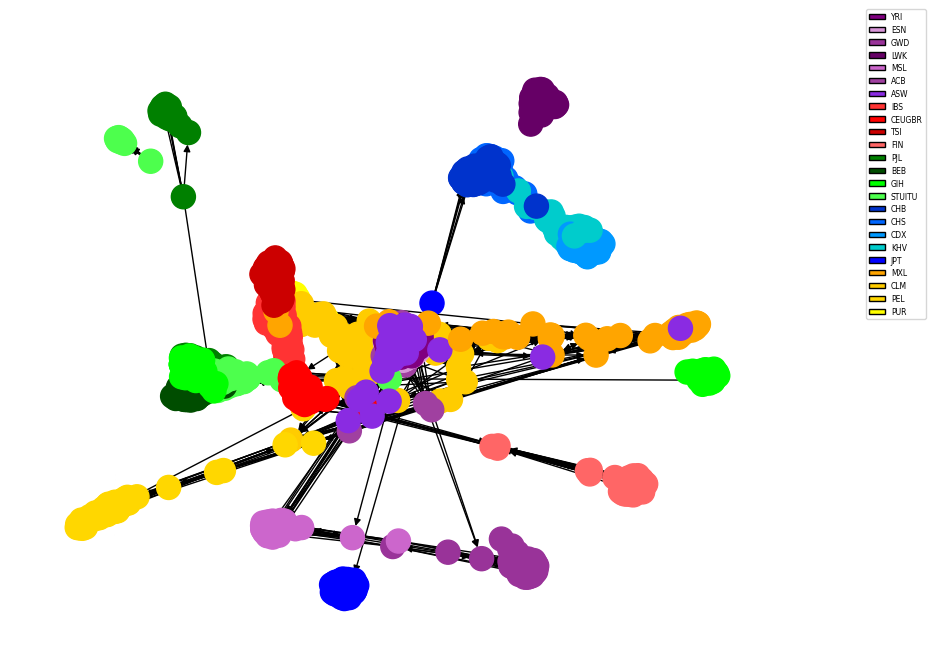

In [10]:
# Now plot the graph
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw(dir_graph, node_color=node_colors, ax=ax)

# Create legend manually
legend_elements = [Patch(facecolor=mappings.pop_pallette_1000G_fine[tgt_name], 
                         edgecolor='k', label=str(tgt_name)) for tgt_name in mappings.label_order_1000G_fine]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.1, 1.05), loc='upper left')

plt.show()

In [11]:
# Find weakly connected components
weakly_connected = list(nx.weakly_connected_components(dir_graph))

# Find strongly connected components
strongly_connected = list(nx.strongly_connected_components(dir_graph))

print('The graph from K has {} strongly connected components.'.format(len(strongly_connected)))
print('The graph from K has {} weakly connected components.'.format(len(weakly_connected)))

The graph from K has 571 strongly connected components.
The graph from K has 5 weakly connected components.


In [12]:
def describe_groups(list_of_groups, label_names):
    compositions = []
    indices = np.zeros(len(label_names))
    sizes = []
    for i, group in enumerate(list_of_groups):
        print('Group {} contains {} points:'.format(i, len(group)))
        classes_in_group = np.array([label_names[k] for k in list(group)])
        class_names, counts = np.unique(classes_in_group, return_counts=True)
        composition = {class_name:count for class_name, count in zip(class_names, counts)}
        print(composition)
        compositions.append(composition)

        indices[list(group)] = i
        
        sizes.append(len(group))

    return compositions, indices, sizes

In [13]:
compositions, indices, sizes = describe_groups(weakly_connected, label_with_names)

Group 0 contains 1329 points:
{'ACB': 96, 'ASW': 61, 'CEUGBR': 107, 'CLM': 94, 'ESN': 99, 'FIN': 99, 'GWD': 113, 'IBS': 107, 'MSL': 85, 'MXL': 64, 'PEL': 85, 'PUR': 104, 'TSI': 107, 'YRI': 108}
Group 1 contains 504 points:
{'CDX': 93, 'CHB': 103, 'CHS': 105, 'JPT': 104, 'KHV': 99}
Group 2 contains 381 points:
{'BEB': 86, 'GIH': 103, 'PJL': 96, 'STUITU': 96}
Group 3 contains 9 points:
{'STUITU': 9}
Group 4 contains 99 points:
{'LWK': 99}


Get diffusion operator and embeddings

In [14]:
test_point = 4

evecs_right, evals, P2, d = compute_dm(K)
diffusion_coords = evecs_right@np.diag(evals)

Dt = compute_diffusion_distance_direct(P2, d/d.sum(), test_point)
Dt2 = compute_diffusion_distance_using_dmcoords(diffusion_coords, test_point)**2

np.allclose(Dt, Dt2)

541 eigenvalues are negative: min=-0.2620297374534701
4 eigenvalues are 1
left evec not exactly stationary dist. Proceed with caution!
right evec not trivial (1s)! Proceed with caution!


True

Compare with diffusion operator

In [15]:
assert len(evecs_right) == np.array(sizes).sum() # same as dataset size!

In [16]:
# get trivial eigenvectors and which samples contain each
trivial_vecs_groups = np.zeros(len(evecs_right))
for i in range(len(evecs_right)):
    zero_idx = np.isclose(evecs_right[:,i],0)
    if zero_idx.sum() > 0:
        max_val = evecs_right[:,i][~zero_idx].min()
        min_val = evecs_right[:,i][~zero_idx].max()
        if np.isclose(max_val, 
                      min_val):
            # print(evecs_right[:,i][~zero_idx][0]) # Trivial vector constant value
            trivial_vecs_groups[~zero_idx] = i

In [17]:
list_of_indices = []
for i in np.unique(trivial_vecs_groups):
    list_of_indices.append(np.where(trivial_vecs_groups == i)[0])

In [18]:
compositions_eig, indices_eig, sizes_eig = describe_groups(list_of_indices, label_with_names)

Group 0 contains 381 points:
{'BEB': 86, 'GIH': 103, 'PJL': 96, 'STUITU': 96}
Group 1 contains 9 points:
{'STUITU': 9}
Group 2 contains 1428 points:
{'ACB': 96, 'ASW': 61, 'CEUGBR': 107, 'CLM': 94, 'ESN': 99, 'FIN': 99, 'GWD': 113, 'IBS': 107, 'LWK': 99, 'MSL': 85, 'MXL': 64, 'PEL': 85, 'PUR': 104, 'TSI': 107, 'YRI': 108}
Group 3 contains 504 points:
{'CDX': 93, 'CHB': 103, 'CHS': 105, 'JPT': 104, 'KHV': 99}


In [19]:
compositions_eig_labels, indices_eig_labels, sizes_eig_labels = describe_groups(weakly_connected, trivial_vecs_groups)

Group 0 contains 1329 points:
{2.0: 1329}
Group 1 contains 504 points:
{3.0: 504}
Group 2 contains 381 points:
{0.0: 381}
Group 3 contains 9 points:
{1.0: 9}
Group 4 contains 99 points:
{2.0: 99}


In [20]:
confusion_matrix = sklearn.metrics.confusion_matrix(indices, indices_eig)

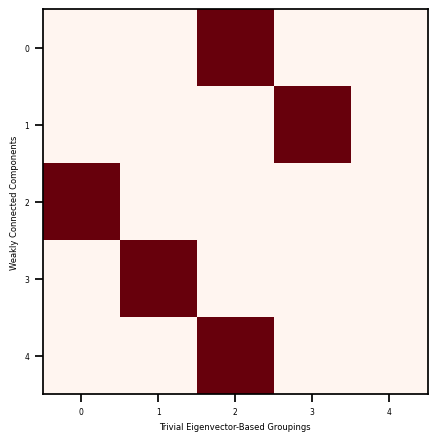

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
_ = ax.imshow(confusion_matrix, cmap='Reds', vmin=0, vmax=1)
_ = ax.set_ylabel('Weakly Connected Components')
_ = ax.set_xlabel('Trivial Eigenvector-Based Groupings')

Now with undirected graph

In [22]:
A = G.knn_tree.kneighbors_graph().todense()
graph_ug = nx.from_numpy_array(A)

# Assign these labels to the nodes
for i, node in enumerate(graph_ug.nodes()):
    graph_ug.nodes[node]['target'] = label_with_names[i]
    graph_ug.nodes[node]['target_sup_pop'] = label_with_superpop_names[i]

node_colors = [mappings.pop_pallette_1000G_fine[graph_ug.nodes[node]['target']] for node in graph_ug.nodes()]

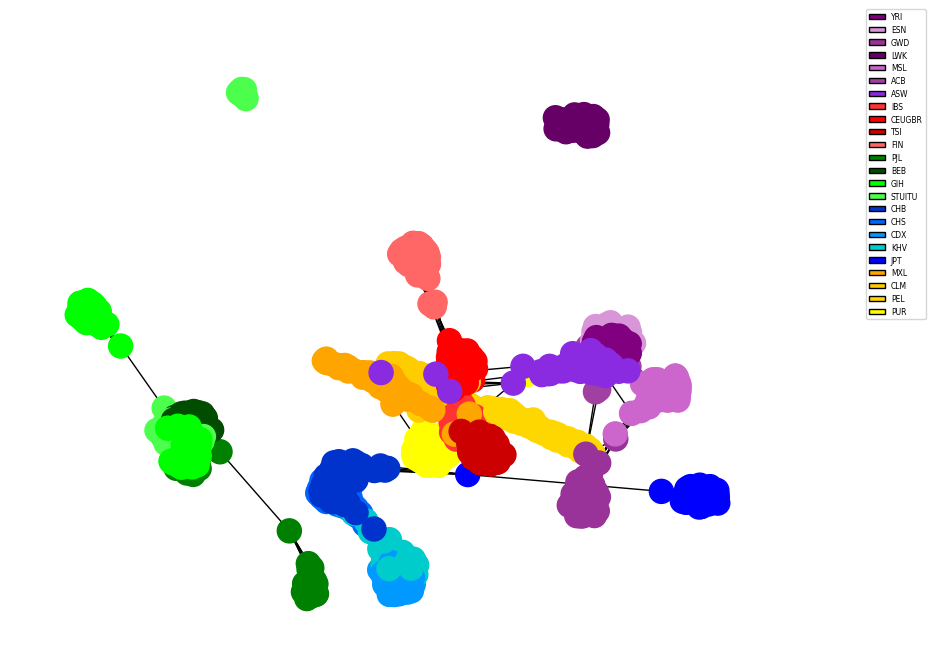

In [23]:
# Now plot the graph
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw(graph_ug, node_color=node_colors, ax=ax)

# Create legend manually
legend_elements = [Patch(facecolor=mappings.pop_pallette_1000G_fine[tgt_name], 
                         edgecolor='k', label=str(tgt_name)) for tgt_name in mappings.label_order_1000G_fine]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.1, 1.05), loc='upper left')

plt.show()

In [24]:
print(nx.is_connected(graph_ug))

# Assuming G is your graph defined elsewhere
# Get connected components as sets of nodes
connected_components_ug = list(nx.connected_components(graph_ug))

# Create a list of subgraphs from each connected component
subgraphs = [graph_ug.subgraph(component).copy() for component in connected_components_ug]

# Now you can process each subgraph individually
for i, sg in enumerate(subgraphs):
    print(f"Subgraph {i+1} has {sg.number_of_nodes()} nodes and {sg.number_of_edges()} edges")
    # You could also plot or analyze each subgraph here

False
Subgraph 1 has 1329 nodes and 6637 edges
Subgraph 2 has 504 nodes and 2430 edges
Subgraph 3 has 381 nodes and 1822 edges
Subgraph 4 has 9 nodes and 32 edges
Subgraph 5 has 99 nodes and 474 edges


In [25]:
compositions_ug, indices_ug, sizes_ug = describe_groups(connected_components_ug, label_with_names)

Group 0 contains 1329 points:
{'ACB': 96, 'ASW': 61, 'CEUGBR': 107, 'CLM': 94, 'ESN': 99, 'FIN': 99, 'GWD': 113, 'IBS': 107, 'MSL': 85, 'MXL': 64, 'PEL': 85, 'PUR': 104, 'TSI': 107, 'YRI': 108}
Group 1 contains 504 points:
{'CDX': 93, 'CHB': 103, 'CHS': 105, 'JPT': 104, 'KHV': 99}
Group 2 contains 381 points:
{'BEB': 86, 'GIH': 103, 'PJL': 96, 'STUITU': 96}
Group 3 contains 9 points:
{'STUITU': 9}
Group 4 contains 99 points:
{'LWK': 99}


In [26]:
confusion_matrix = sklearn.metrics.confusion_matrix(indices, indices_ug)

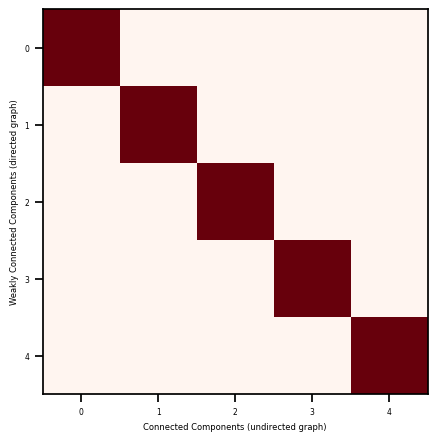

In [27]:
fig, ax = plt.subplots(figsize=(5,5))
_ = ax.imshow(confusion_matrix, cmap='Reds', vmin=0, vmax=1)
_ = ax.set_ylabel('Weakly Connected Components (directed graph)')
_ = ax.set_xlabel('Connected Components (undirected graph)')